# Baseline N = 1 and only using location

In [1]:
import sys
import os
from datetime import datetime
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
sys.path.append(os.path.abspath('../src'))
from lib import (
    train_and_evaluate_models,
    create_eui_comparison_plots,
    evaluate_model_strategies,
    calculate_average_metrics,
    create_error_distribution_plots
)

In [3]:
output_path = "../data/03_processed/merged_df.csv"
merged_df = pd.read_csv(output_path)
merged_df = merged_df.rename(columns={'total_year': 'hdd_total_year'})

# GDP per capita
merged_df['GDP_per_capita'] = merged_df['GDP_2022'] / merged_df['Population_2023']

# Delete Taiwan (temporal)
merged_df = merged_df[merged_df['Country'] != 'Taiwan']

#np.random.seed(123)
#merged_df['is_train'] = np.random.choice([1, 0], size=len(merged_df), p=[0.8, 0.2])

# Train / Test

In [4]:
train_test_split_original_data_path = "../data/03_processed/train_test_split_original_data.csv"
train_test_split_original_data = pd.read_csv(train_test_split_original_data_path)

train_test_split_new_data_path = "../data/03_processed/train_test_split_new_data.csv"
train_test_split_new_data = pd.read_csv(train_test_split_new_data_path)

train_test_split = pd.concat([train_test_split_original_data, train_test_split_new_data], ignore_index=True)

merged_df = merged_df.merge(train_test_split, on=['index', 'geonameid'], how='left')

# We want to keep original data 
merged_df = merged_df[merged_df["source"] == "World Bank CURB"]

# Delete Image Null

In [5]:
print(merged_df.shape)

merged_df = merged_df.dropna(subset=['pca_result'])

print(merged_df.shape)

(481, 67)
(473, 67)


In [6]:
feature_selection = "all_features"
#feature_selection = "selected_features"

features = [
    # "hdd_total_year", 
    # "cdd_total_year", 
    # "GDP_per_capita", 
    # "Urbanization_Rate_2022",
    "latitude",
    "longitude",  
    # "Paris_Agreement",
    # "Subnational HDI", 
    # "Educational index", 
    # "Income index",
    # "2m_temperature_2023_avg",
    # "2m_dewpoint_temperature_2023_avg",
    # "total_precipitation_2023",
    # "longitude_sin", 
    # "longitude_cos", 
    # "latitude_sin", 
    # "latitude_cos",  
    # "population_density",

    # Image data
    
    # "pca_result", 
    # "K_mean_label", 
    # "C_mean_label", 
    # "GMM_label", 
    # "Cluster_1",
    # "Cluster_2", 
    # "Cluster_3",
    # "Cluster_4", 
    # "Cluster_5",
    # "Cluster_6", 
    # "Cluster_7", 
    # "Cluster_8", 
    # "Cluster_9", 
    # "Cluster_10",
    # "Cluster_11", 
    # "Cluster_12", 
    # "Cluster_13", 
    # "Cluster_14", 
    # "Cluster_15",
    # "Cluster_16", 
    # "Cluster_17", 
    # "Cluster_18", 
    # "Cluster_19"
]

feature_abbreviations = {
    # "hdd_total_year": "HDD",
    # "cdd_total_year": "CDD", 
    # "GDP_per_capita": "GDP",
    # "Urbanization_Rate_2022": "URB",
    "latitude": "Lat",
    "longitude": "Long",
    # "Paris_Agreement": "Paris",
    # "Subnational HDI": "HDI", 
    # "Educational index": "EDU", 
    # "Income index": "Income",
    # "2m_temperature_2023_avg": "Temp",
    # "2m_dewpoint_temperature_2023_avg": "Dew",
    # "total_precipitation_2023": "Precip",
    # "longitude_sin": "Long_Sin", 
    # "longitude_cos": "Long_Cos", 
    # "latitude_sin": "Lat_Sin", 
    # "latitude_cos": "Lat_Cos",  
    # "population_density": "Pop_Dens",
    # "pca_result": "PCA",
    # "Cluster_1": "C1",
    # "Cluster_2": "C2",
    # "Cluster_3": "C3",
    # "Cluster_4": "C4",
    # "Cluster_5": "C5",
    # "Cluster_6": "C6",
    # "Cluster_7": "C7",
    # "Cluster_8": "C8",
    # "Cluster_9": "C9",
    # "Cluster_10": "C10",
    # "Cluster_11": "C11",
    # "Cluster_12": "C12",
    # "Cluster_13": "C13",
    # "Cluster_14": "C14",
    # "Cluster_15": "C15",
    # "Cluster_16": "C16",
    # "Cluster_17": "C17",
    # "Cluster_18": "C18",
    # "Cluster_19": "C19"
}


target_columns = [
    "Residential EUI (kWh/m2/year)",
    "Non-residential EUI (kWh/m2/year)"
]

regions = ['Asia & Oceania', 'Europe', 'Africa', 'Central and South America', 'Northern America']


# KNN

In [7]:
knn_params = {
    'n_neighbors': 1,          # number of neighbors
   # 'weights': 'distance',     # weight points by inverse of their distance
   # 'algorithm': 'auto',       # automatically choose the best algorithm
   # 'leaf_size': 30,          # leaf size for tree algorithms
   # 'p': 2,                   # power parameter for Minkowski metric (2 = Euclidean distance)
   # 'metric': 'minkowski',     # distance metric to use
   # 'n_jobs': -1              # use all available cores
}

### KNN - Within Domain

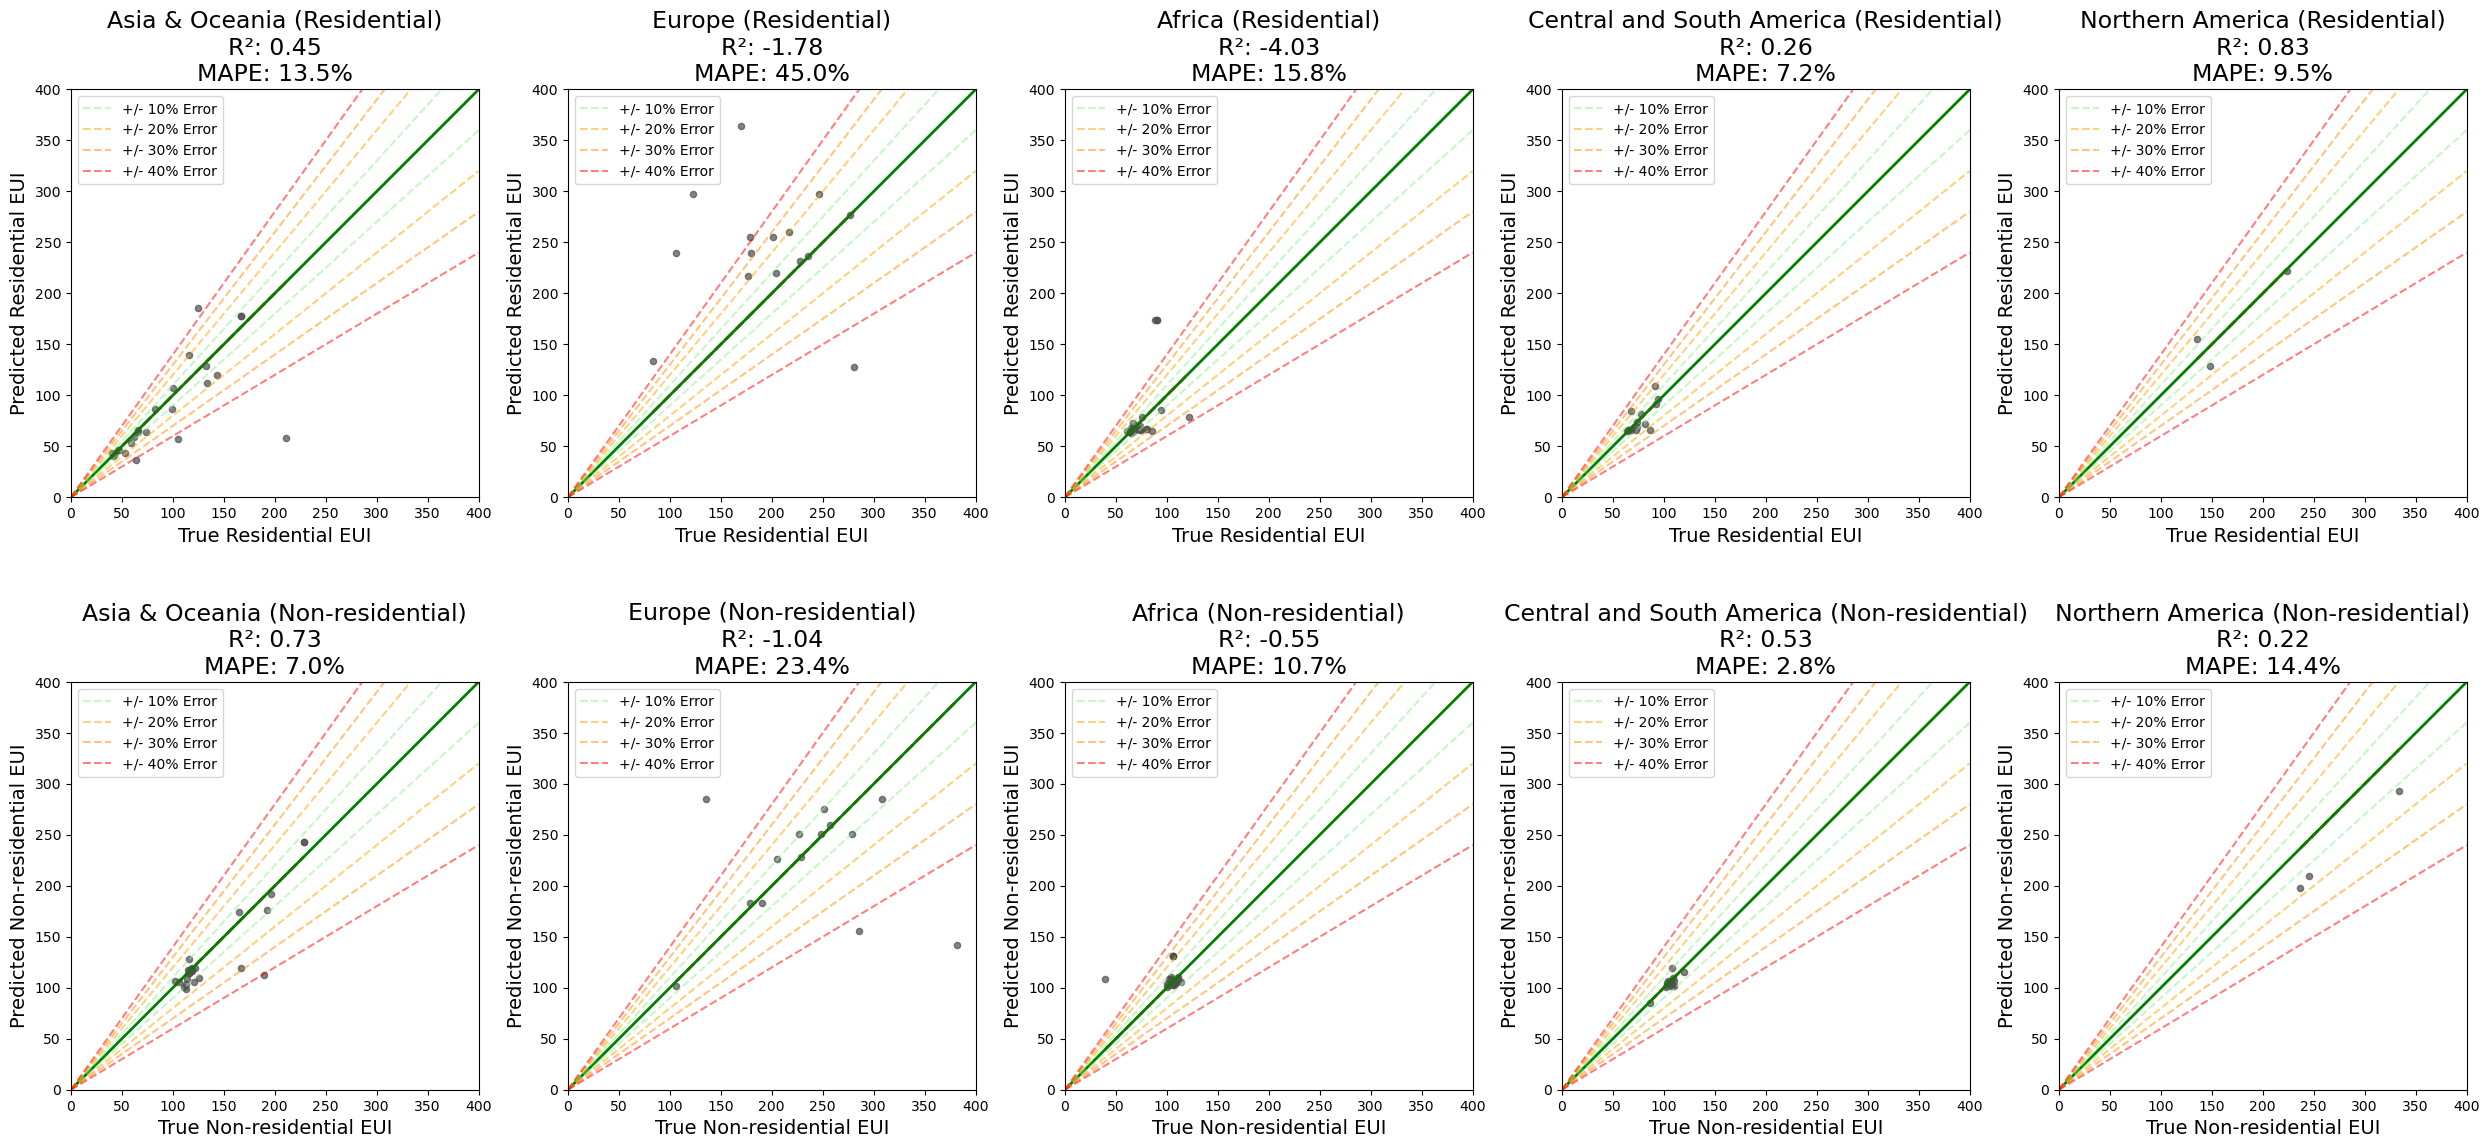

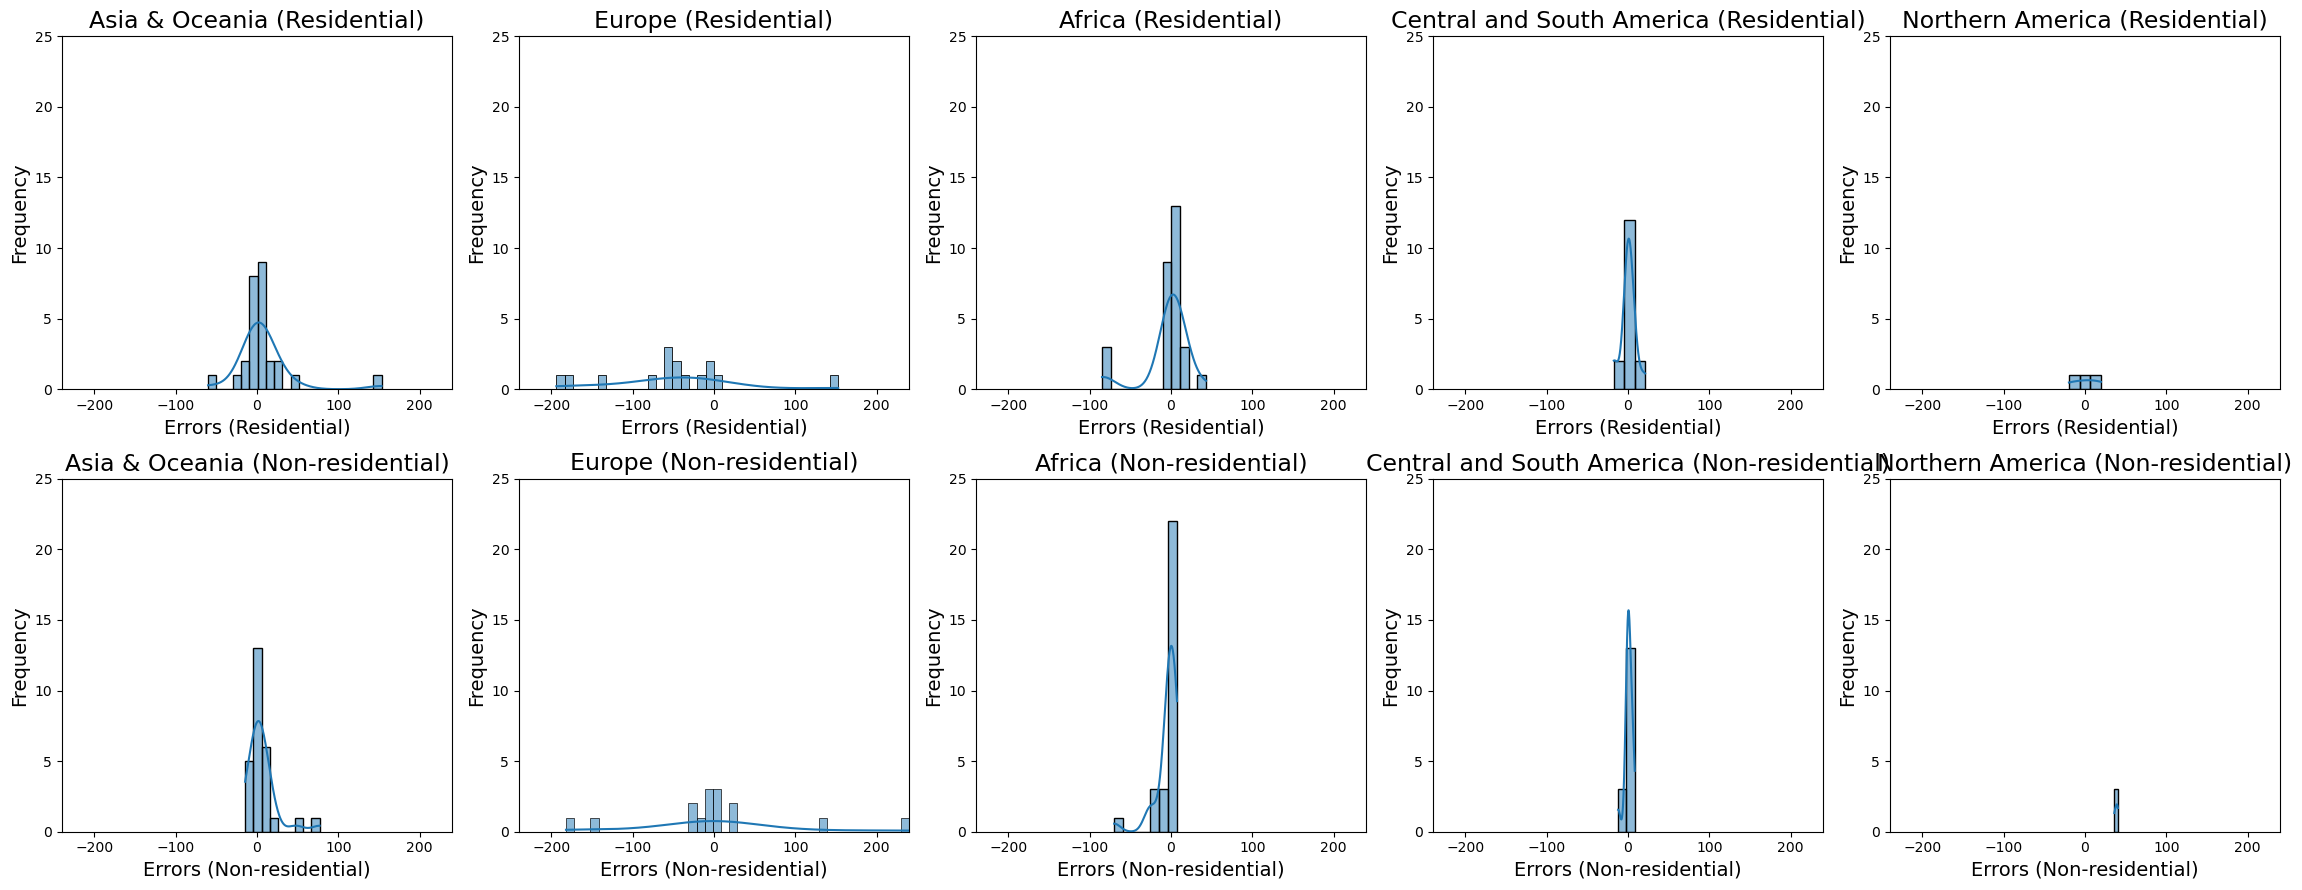

In [8]:
# Within-domain
model_knn_within = KNeighborsRegressor(**knn_params)
results_knn_within = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_knn_within,
    strategy='within_domain'
)

create_eui_comparison_plots(
    results_knn_within, 
    save_path=f'../figures/model_plots/{feature_selection}/knn_within_domain_eui_predictions.png'
)

create_error_distribution_plots(
    results_knn_within,
    save_path=f'../figures/model_plots/{feature_selection}/knn_within_domain_error_distribution.png'
)


KNN - Cross Domain

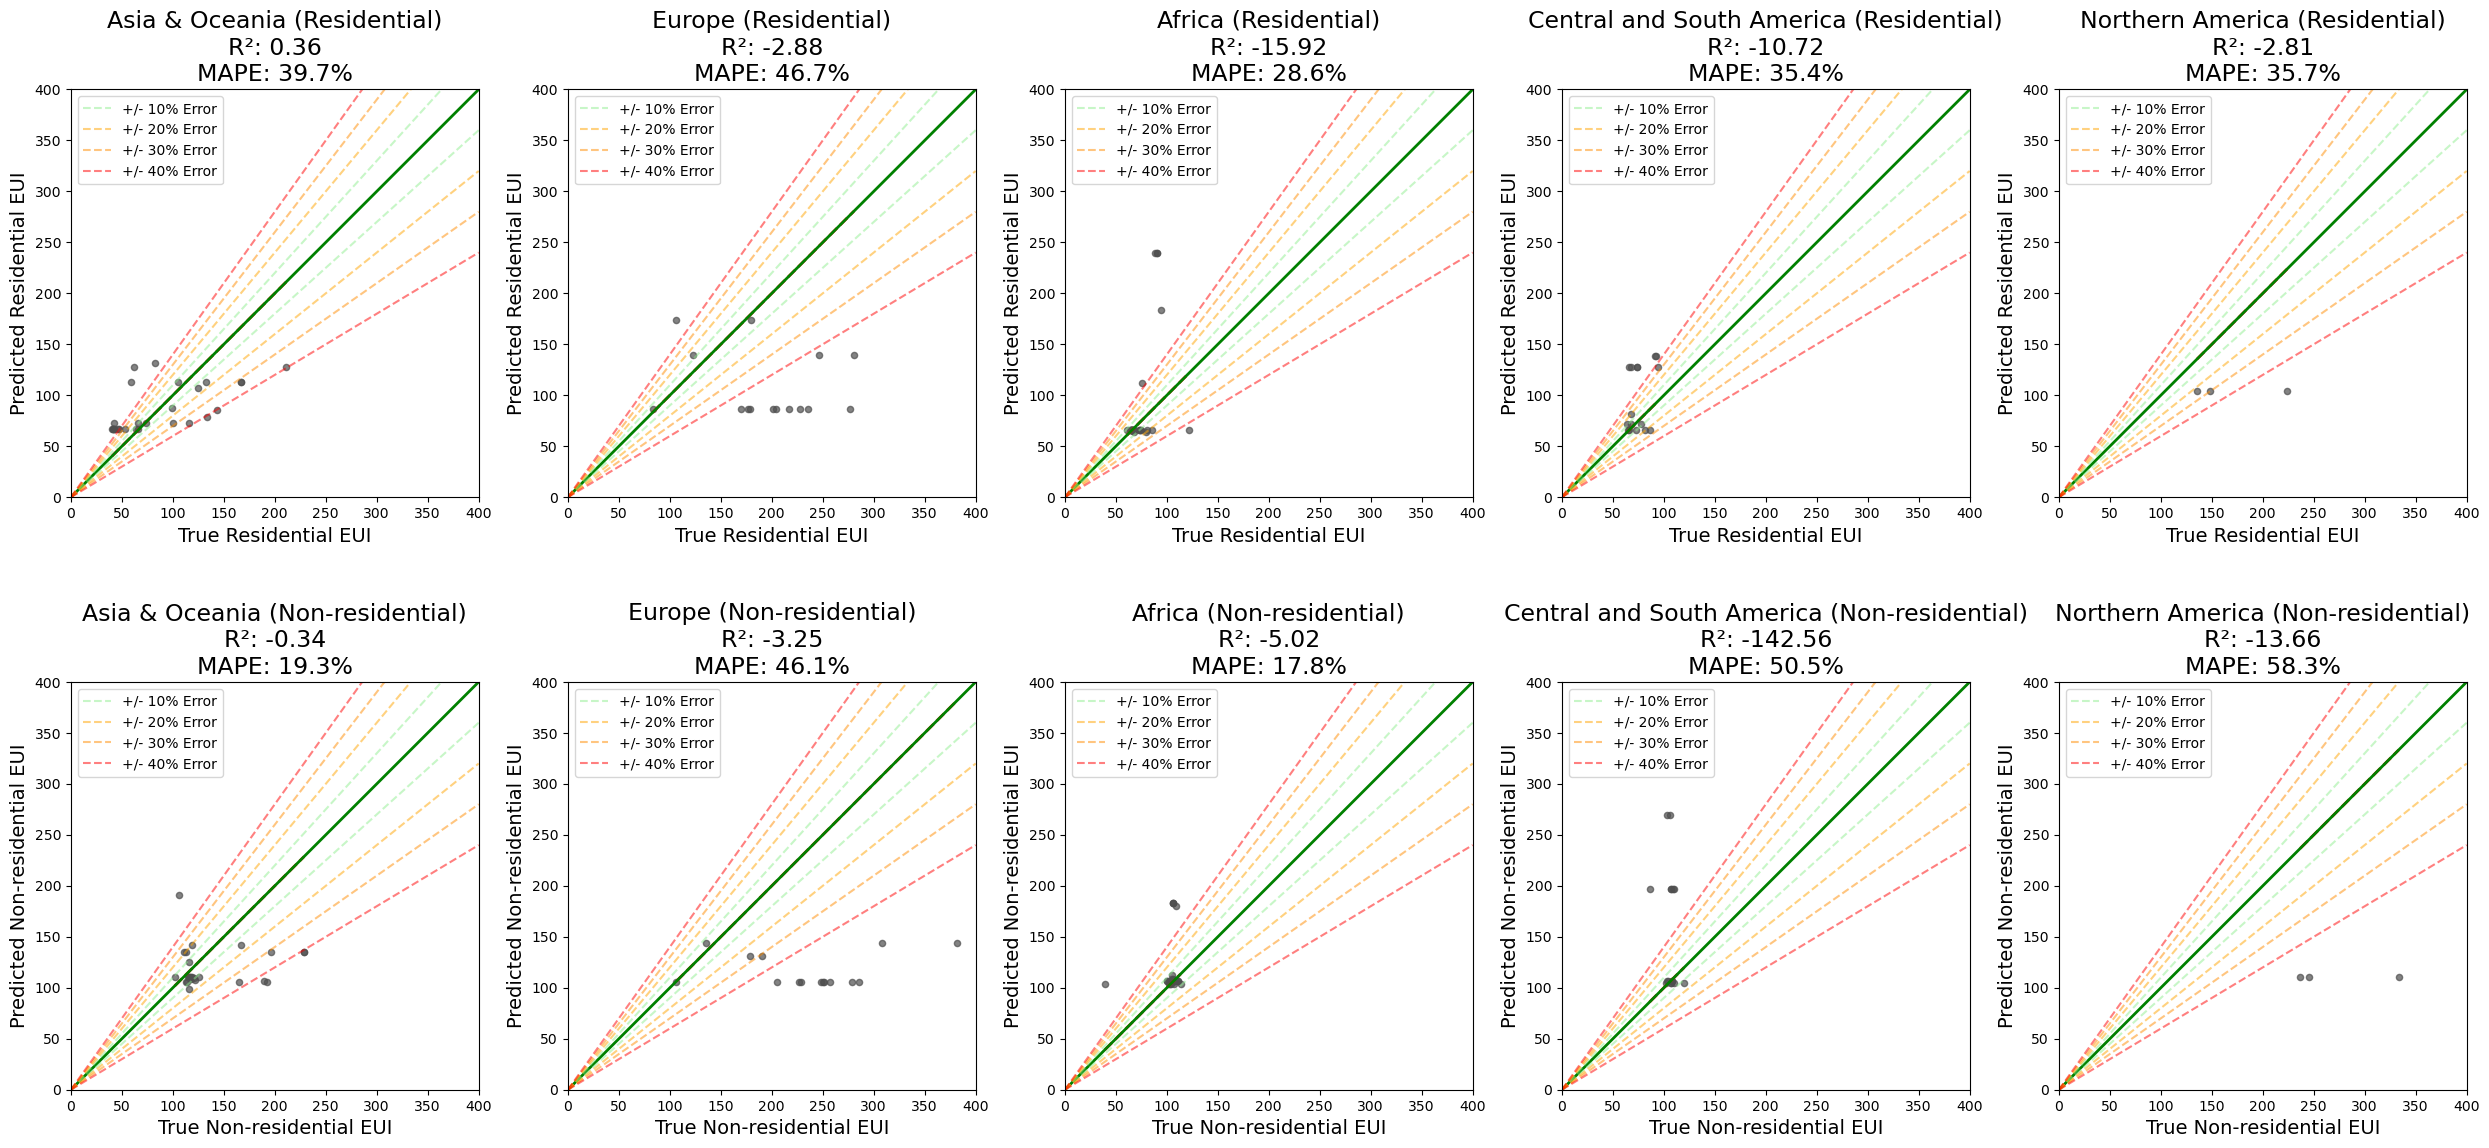

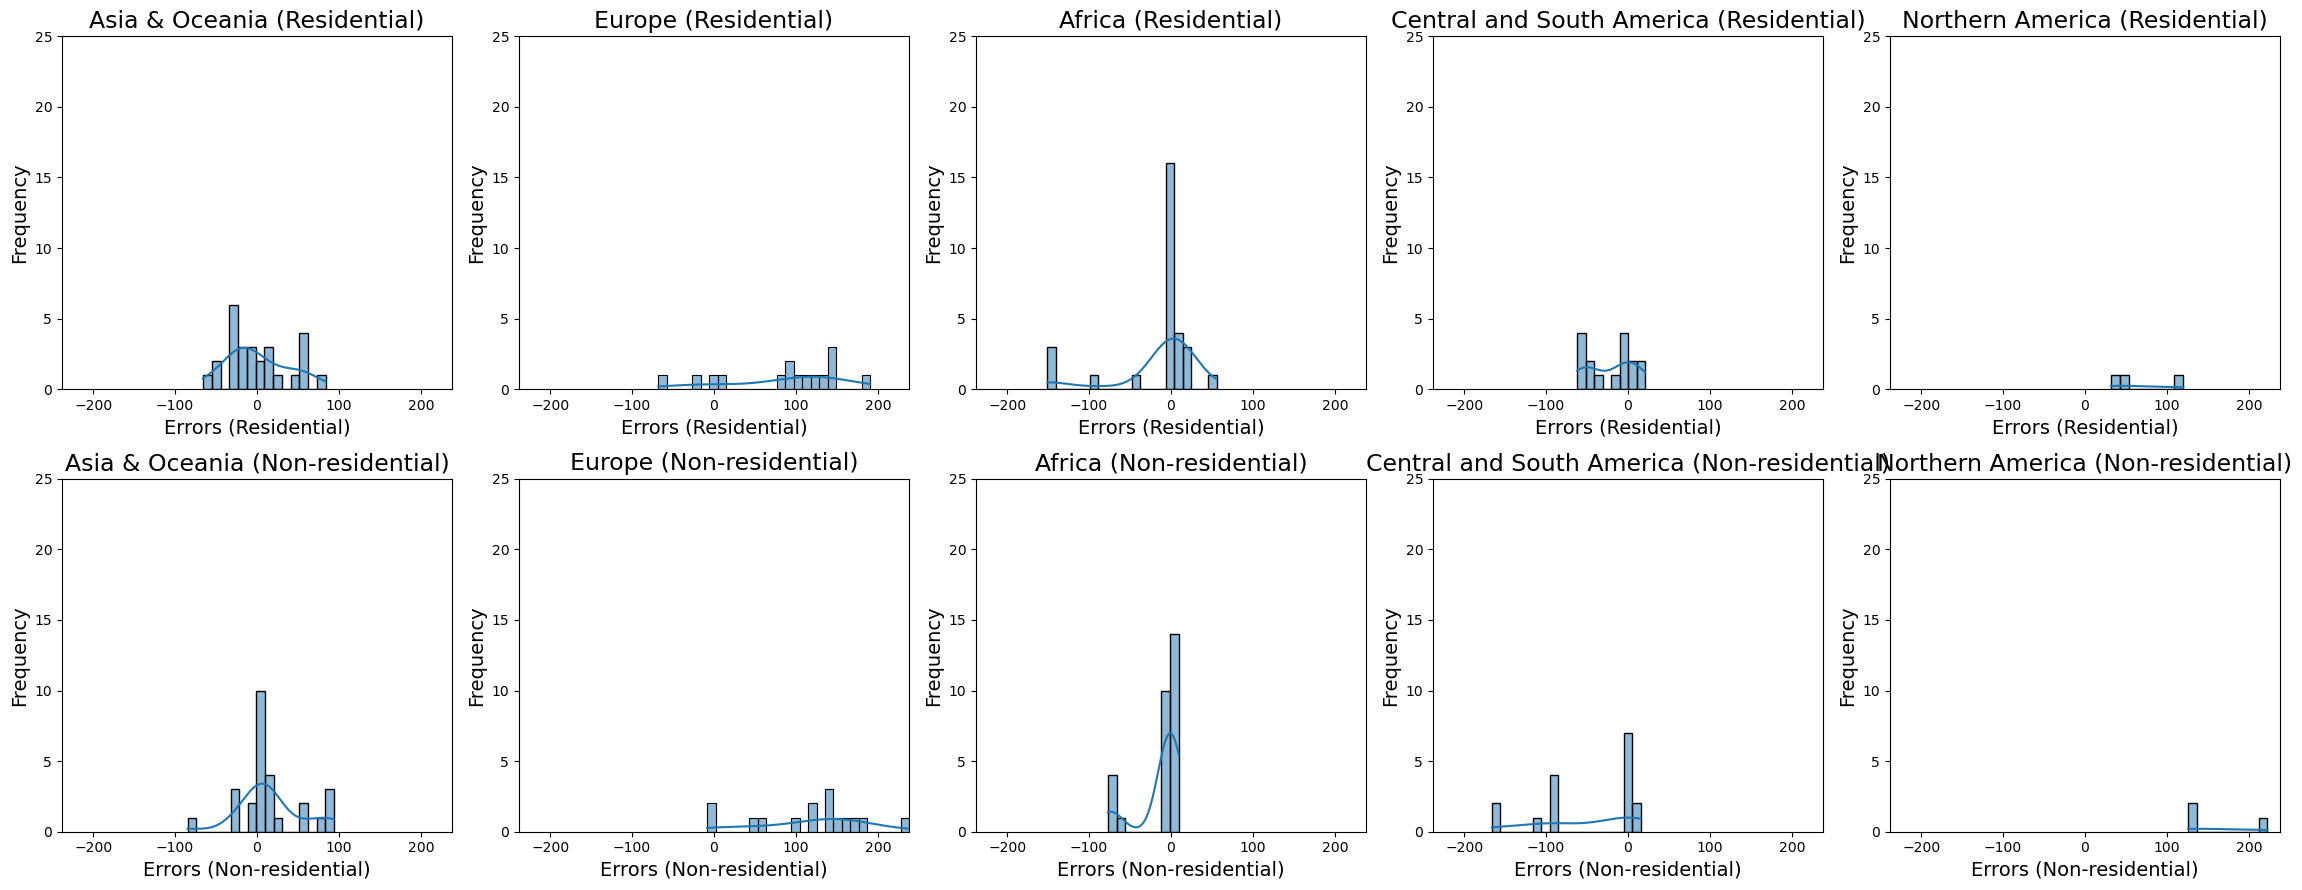

In [9]:
# Cross-domain
model_knn_cross = KNeighborsRegressor(**knn_params)
results_knn_cross = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_knn_cross,
    strategy='cross_domain'
)

create_eui_comparison_plots(
    results_knn_cross,
    save_path=f'../figures/model_plots/{feature_selection}/knn_cross_domain_eui_predictions.png'
)

create_error_distribution_plots(
    results_knn_cross,
    save_path=f'../figures/model_plots/{feature_selection}/knn_cross_domain_error_distribution.png'
)


### KNN - All Domain

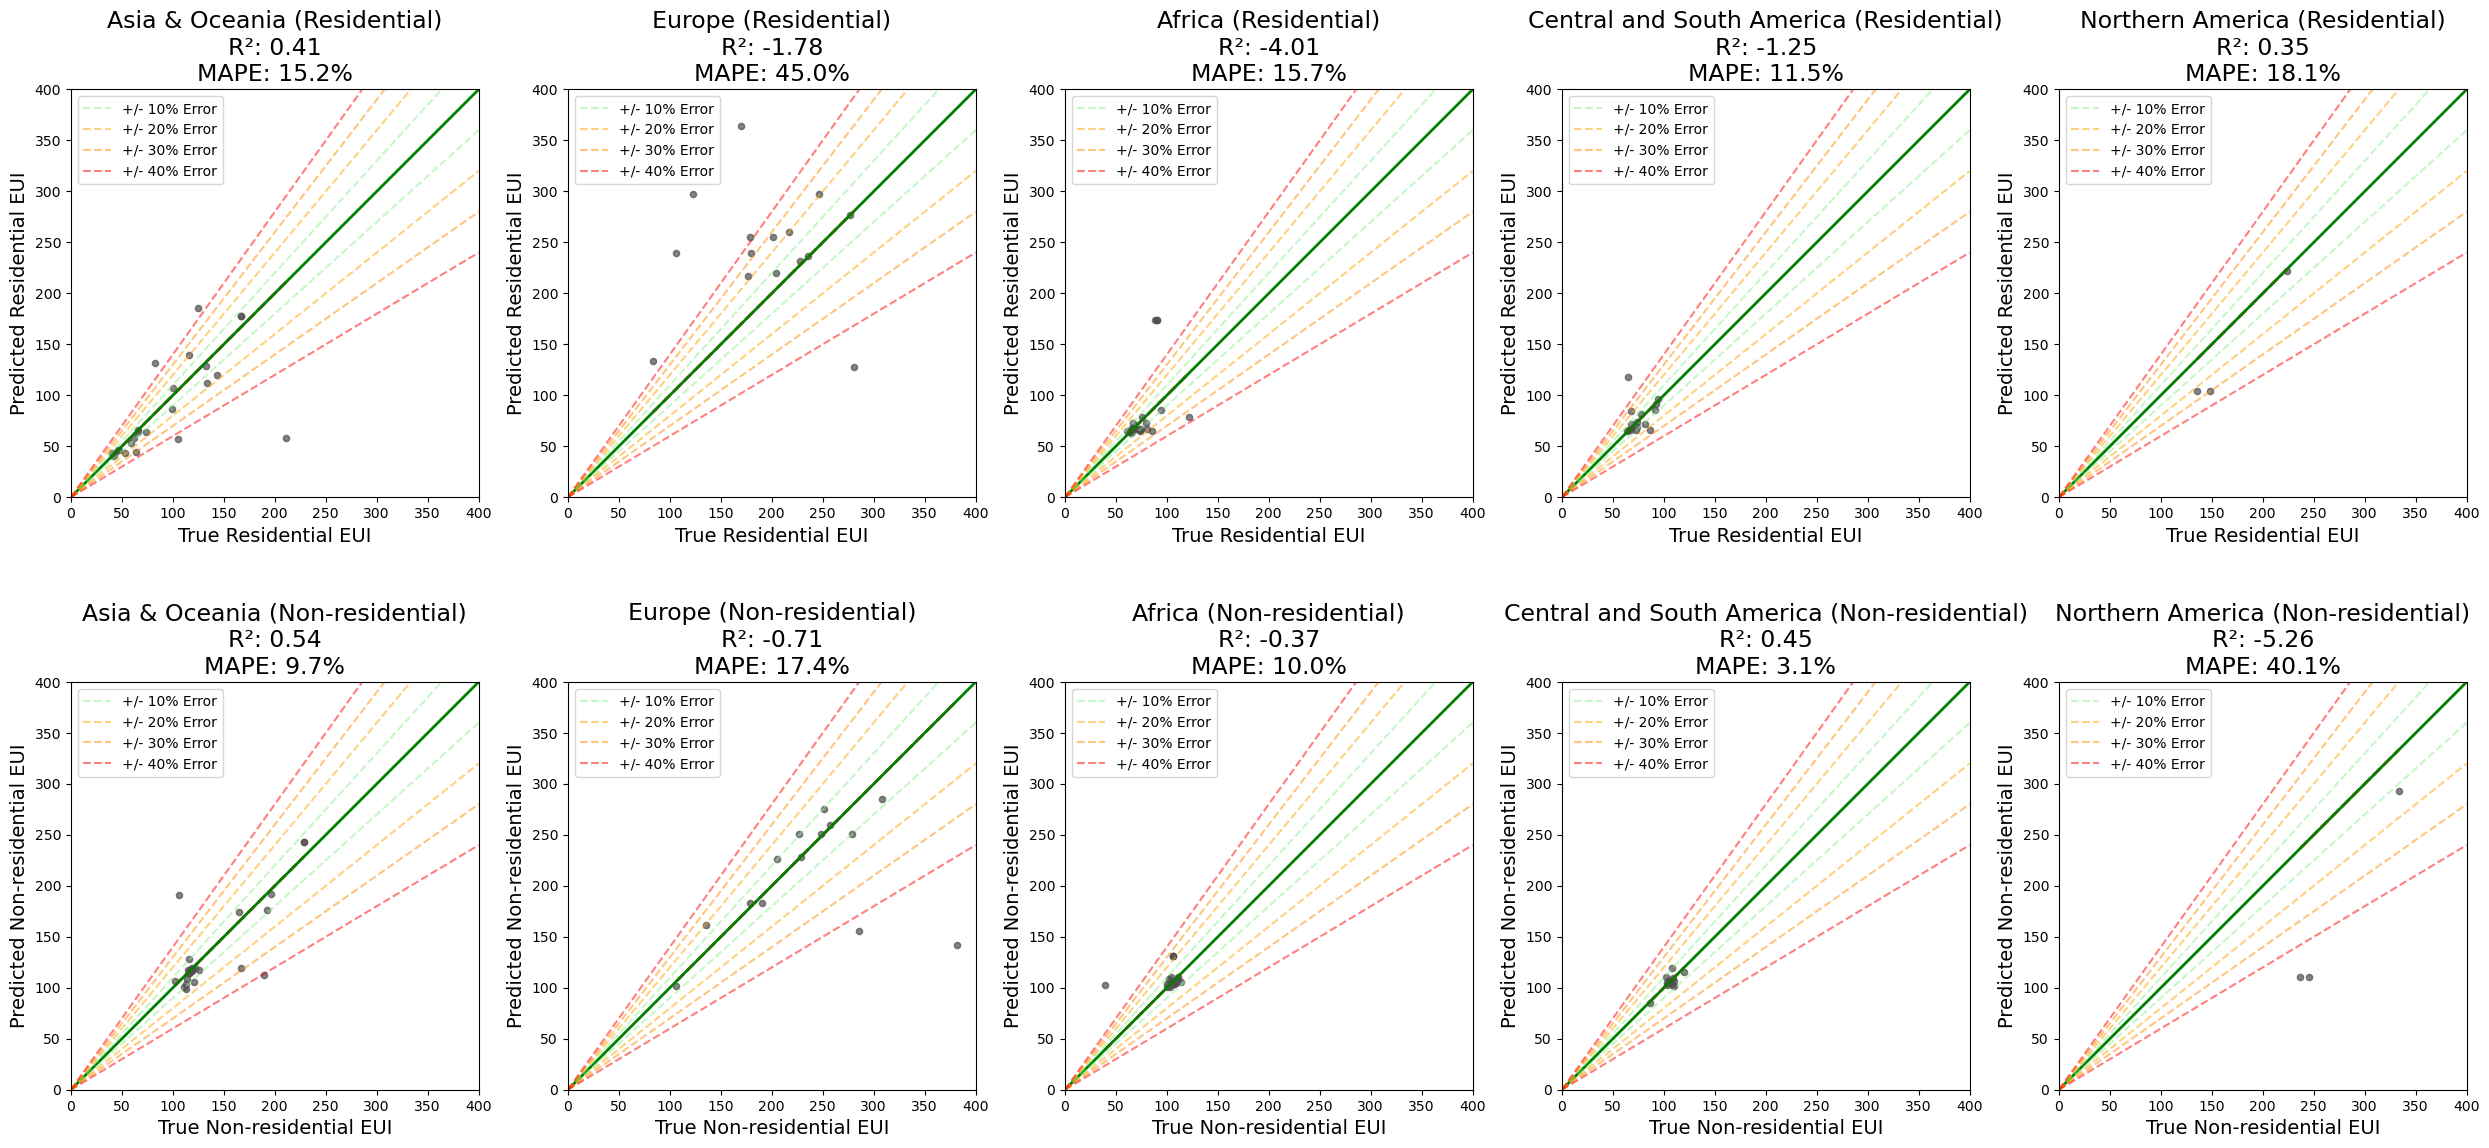

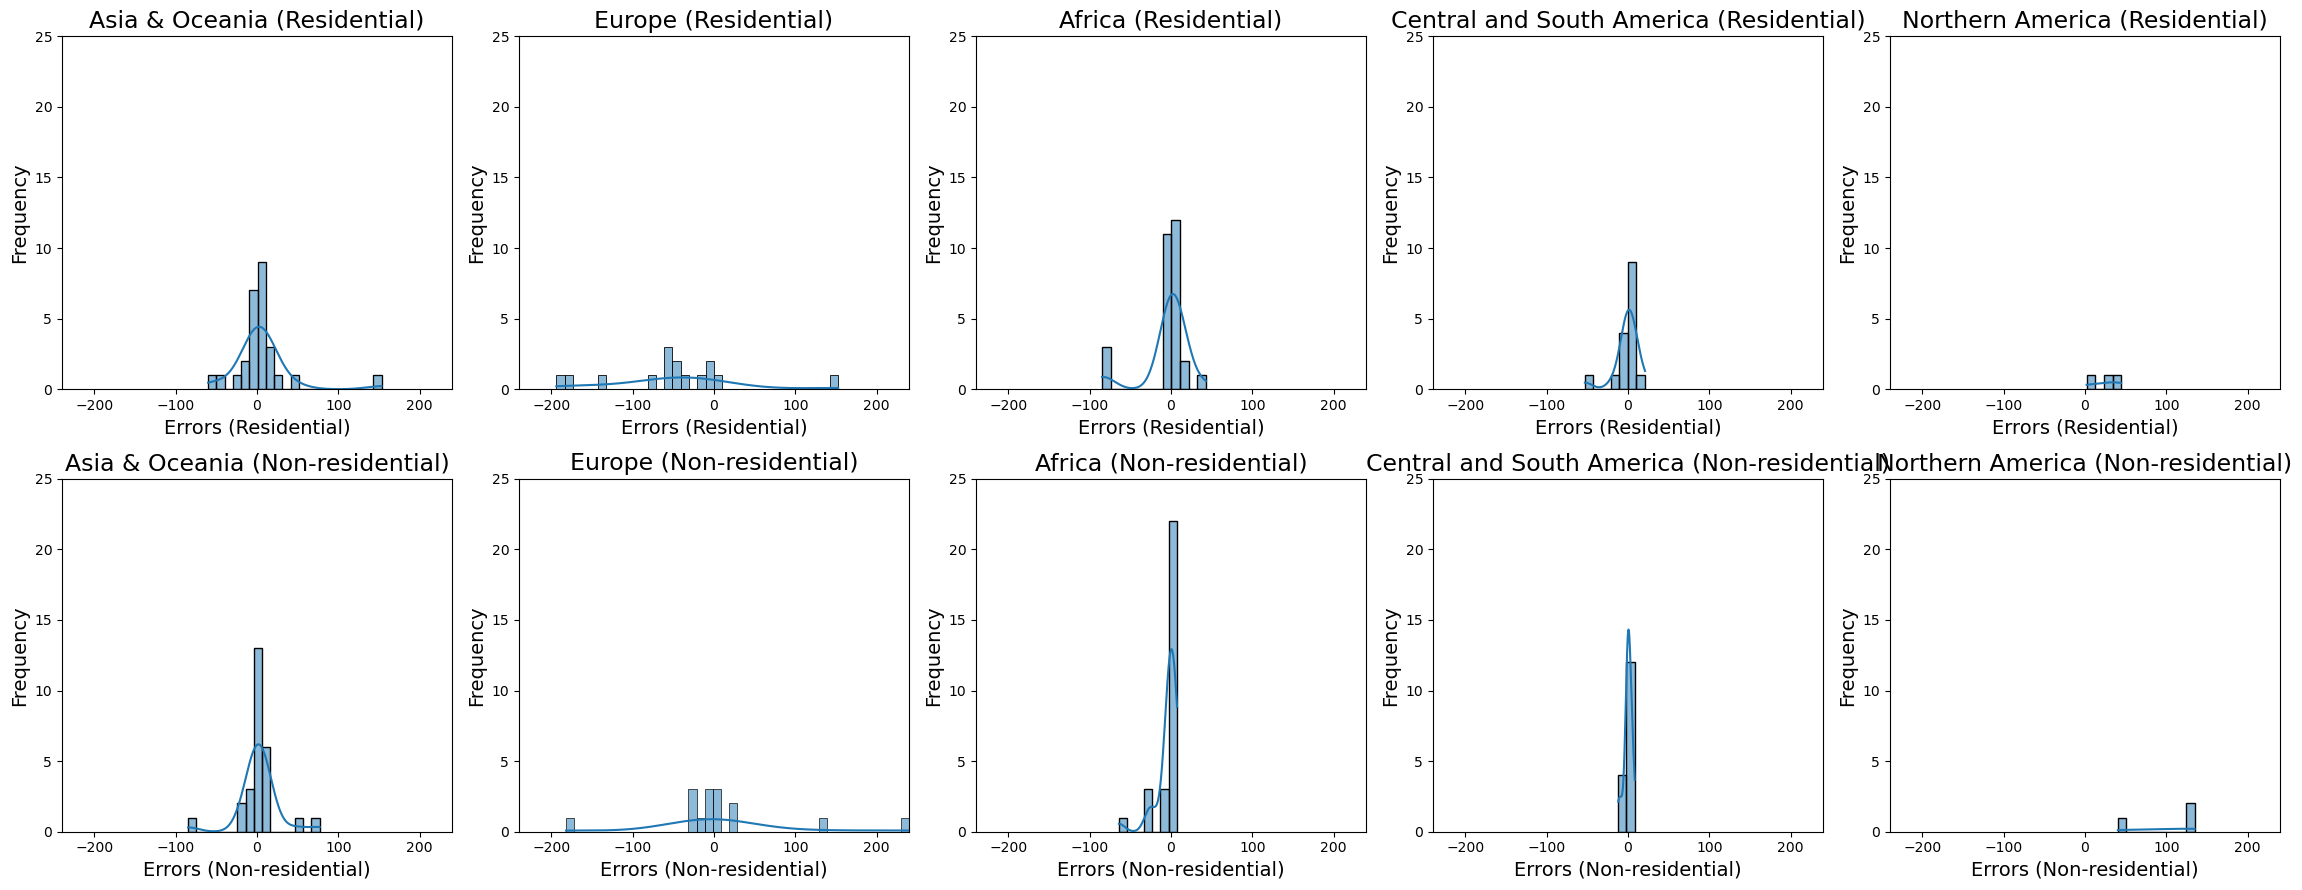

In [10]:
# All-domain
model_knn_all = KNeighborsRegressor(**knn_params)
results_knn_all = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_knn_all,
    strategy='all_domain'
)

create_eui_comparison_plots(
    results_knn_all,
    save_path=f'../figures/model_plots/{feature_selection}/knn_all_domain_eui_predictions.png'
)

create_error_distribution_plots(
    results_knn_all,
    save_path=f'../figures/model_plots/{feature_selection}/knn_all_domain_error_distribution.png'
)


In [11]:
KNNModel = lambda: KNeighborsRegressor(**knn_params)

knn_detailed_results = evaluate_model_strategies(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model_type=KNNModel,  
    feature_abbreviations=feature_abbreviations,
    model_details= ", ".join(f"{k}={v}" for k, v in knn_params.items())
)

knn_detailed_results['Model'] = 'KNeighborsRegressor'
knn_average_results = calculate_average_metrics(knn_detailed_results).reset_index()
knn_average_results

,Target,Strategy,Model,Model Details,Features Used,Features Abbreviated,MAPE,R²,MSE,RMSE,MAE,WAPE
0,Non-residential EUI (kWh/m2/year),within_domain,KNeighborsRegressor,n_neighbors=1,"latitude, longitude",Lat | Long,11.66,-0.023,2196.831,34.429,23.092,11.08
1,Non-residential EUI (kWh/m2/year),cross_domain,KNeighborsRegressor,n_neighbors=1,"latitude, longitude",Lat | Long,38.40,-32.965,11058.675,91.044,75.644,39.20
2,Non-residential EUI (kWh/m2/year),all_domain,KNeighborsRegressor,n_neighbors=1,"latitude, longitude",Lat | Long,16.06,-1.069,4040.621,48.004,34.400,15.38
3,Residential EUI (kWh/m2/year),within_domain,KNeighborsRegressor,n_neighbors=1,"latitude, longitude",Lat | Long,18.20,-0.854,2219.349,36.352,23.977,17.84
4,Residential EUI (kWh/m2/year),cross_domain,KNeighborsRegressor,n_neighbors=1,"latitude, longitude",Lat | Long,37.22,-6.397,4679.926,62.368,49.056,38.70
5,Residential EUI (kWh/m2/year),all_domain,KNeighborsRegressor,n_neighbors=1,"latitude, longitude",Lat | Long,21.10,-1.257,2410.082,40.953,27.209,20.30


In [12]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
knn_detailed_results.to_csv(f'../results/{feature_selection}/{timestamp}_knn_detailed_results.csv')
knn_average_results.to_csv(f'../results/{feature_selection}/{timestamp}_knn_average_results.csv')


# 